Halo connectivity of objects

This notebook is going to explore creating halo's around 'coral' objects that can be used to identify connectivity between corals through the flow. I think these halo's can be defined in the analysis part of the study, so all particleset output can be used

Let's import the modules and define the output files to be analysed

In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import timedelta
import xarray as xr
from explfunctions import coraldistancemap, followPath
import cmocean
import seaborn as sns

In [2]:
name = 'output-corals-regridded'
fb = 'forward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
runtime=timedelta(seconds=10)                            # total time to execute the particleset
outputdt = timedelta(seconds=0.01)
filename = name+'.nc'

In [3]:
flowdata = xr.open_dataset(filename)

Now we are going to use the flowdata to retrieve the mask and subsequently create a mask of the 'coastal' gridpoints, which are the coral gridpoints that border the flow. These will be used to calculate the distance to the nearest coral object.

In [4]:
umask = np.ma.masked_invalid(flowdata['U'][0])

The points needed to find the smallest distance to the corals are all the coral points that do not have their four nearest neighbours as coral cells. In the middle of the grid we check if i+1, i-1, j+1 and j-1 are True. At the borders we create exceptions so the index does not become out of bounds.

In [5]:
# cmask=np.copy(umask.mask)
# for i in range(len(umask)):
#     for j in range(len(umask[i])):
#         if umask.mask[i,j] == True:
#             if i>0 and i<len(umask)-1 and j>0 and j<len(umask[i])-1:
#                 if umask.mask[i-1,j]==True and umask.mask[i+1,j]==True and umask.mask[i,j-1]==True and umask.mask[i,j+1]==True:
#                     cmask[i,j]=False
#             elif i==0 and j>0 and j<len(umask[i])-1:
#                 if umask.mask[i+1,j]==True and umask.mask[i,j-1]==True and umask.mask[i,j+1]==True:
#                     cmask[i,j]=False
#             elif i==len(umask)-1 and j>0 and j<len(umask[i])-1:
#                 if umask.mask[i-1,j]==True and umask.mask[i,j-1]==True and umask.mask[i,j+1]==True:
#                     cmask[i,j]=False
#             elif i>0 and i<len(umask)-1 and j==0:
#                 if umask.mask[i-1,j]==True and umask.mask[i+1,j]==True and umask.mask[i,j+1]==True:
#                     cmask[i,j]=False
#             elif i>0 and i<len(umask)-1 and j==len(umask[i])-1:
#                 if umask.mask[i-1,j]==True and umask.mask[i+1,j]==True and umask.mask[i,j-1]==True:
#                     cmask[i,j]=False
#             elif i==0 and j==0:
#                 if umask.mask[i+1,j]==True and umask.mask[i,j+1]==True:
#                     cmask[i,j]=False
#             elif i==0 and j==len(umask[i])-1:
#                 if umask.mask[i+1,j]==True and umask.mask[i,j-1]==True:
#                     cmask[i,j]=False
#             elif i==len(umask)-1 and j==0:
#                 if umask.mask[i-1,j]==True and umask.mask[i,j+1]==True:
#                     cmask[i,j]=False
#             elif i==len(umask)-1 and j==len(umask[i])-1:
#                 if umask.mask[i-1,j]==True and umask.mask[i,j-1]==True:
#                     cmask[i,j]=False
# np.save('coastmask',cmask,allow_pickle=True)

In [6]:
xmesh,ymesh = np.meshgrid(flowdata['X'],flowdata['Y'])

Create the distance map called coralmap by calling function and passing the mask of all coral cells, the mask of the 'coastal' cells and the meshgrid. Then either save or load the coralmap

In [7]:
# mat,coralmap = coraldistancemap(umask.mask,cmask,xmesh,ymesh)
# np.save('coralmap',coralmap,allow_pickle=True)
coralmap = np.load('coralmap.npy')

Plot the distance map with the coral objects masked

In [45]:
%matplotlib qt
fig = plt.figure(figsize=(18,2))
ax = plt.axes()
ax.set_facecolor('k')
ax.contourf(flowdata['X'],flowdata['Y'],flowdata['U'][0],np.linspace(-10,-9,21),extend='both',cmap=cmocean.cm.ice)
sc = ax.scatter(xmesh[~umask.mask],ymesh[~umask.mask],c=coralmap[~umask.mask],s=10,cmap=cmocean.cm.amp)
cbar = fig.colorbar(sc,label='Distance from coral [m]')
plt.ylim(flowdata['Y'][-1],flowdata['Y'][0])
plt.xlim(flowdata['X'][0],flowdata['X'][-1])
plt.ylabel('Height [m]')
plt.xlabel('Horizontal distance [m]')

Text(0.5, 0, 'Horizontal distance [m]')

Now analyse the particle output with the information on distance to the nearest coral

In [9]:
name = 'output-corals-regridded'
fb = 'backward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
runtime=timedelta(seconds=10)                            # total time to execute the particleset
outputdt = timedelta(seconds=0.1)
filename = name+'.nc'
dfilename = name+fb+str(runtime.seconds)+'.nc'

In [10]:
distdata = xr.open_dataset(dfilename)

flowdata = xr.open_dataset(filename)

In [11]:
x,y = np.meshgrid(flowdata['X'],flowdata['Y'])
um = np.ma.masked_invalid(flowdata['U'][0,:,:])                    # retrieve mask from flowfield to take out points over coral objects

lons = np.ma.masked_array(x,mask=um.mask)             # mask points in meshgrid
lons = lons.flatten()
ds = np.ma.masked_array(y,mask=um.mask)                 # mask points in meshgrid
ds = ds.flatten()

usm = np.invert(um.mask)
lonm = np.ma.masked_array(x,mask=usm)             # mask points in meshgrid
lonm = lonm.flatten()
dm = np.ma.masked_array(y,mask=usm)                 # mask points in meshgrid
dm = dm.flatten()

In [12]:
# traj = 68000
# fig = plt.figure(figsize=(18,2))
# ax = plt.axes()
# ax.set_facecolor('k')
# # ax.scatter(lons,ds,s=7,c='c',label='flow gridpoint')
# # ax.scatter(lonm,dm,s=15,c='k',label='coral gridpoint')
# ax.contourf(flowdata['X'],flowdata['Y'],flowdata['U'][0],np.linspace(-10,-9,21),extend='both',cmap=cmocean.cm.ice)
# sc = ax.scatter(distdata['lon'].isel(traj=traj,obs=slice(1,-1)),-distdata['z'].isel(traj=traj,obs=slice(1,-1)),c=distdata['d2c'].isel(traj=traj,obs=slice(1,-1)),marker='o',cmap=cmocean.cm.amp_r)
# cbar = fig.colorbar(sc,label='Distance from coral [m]')
# plt.ylabel('Height [m]')
# plt.xlabel('Horizontal distance [m]')
# plt.ylim(flowdata['Y'][-1],flowdata['Y'][0])
# plt.xlim(flowdata['X'][0],flowdata['X'][-1])

Now that we have the halo with distances, we want to analyse the particles that start near the corals.
Secondly we will try to separate the different coral objects and observe their interconnectivity

In [13]:
d2cmax = 0.02
ddata = distdata.where(distdata['d2c'][:,1]<d2cmax,drop=True)

Plot the particles where the initial distance to the coral is smaller than d2cmax

In [14]:
# fig = plt.figure(figsize=(18,2))
# ax = plt.axes()
# ax.scatter(ddata['lon'][:,1],-ddata['z'][:,1],s=7)

In [15]:
# fig = plt.figure(figsize=(18,4))
# ax = plt.axes()
# ax.set_facecolor('k')
# cf = ax.contourf(flowdata['X'],flowdata['Y'],flowdata['U'][8,:,:],np.linspace(-10,-9,21),extend='both',cmap='cool_r')
# sc = ax.scatter(ddata['lon'][:,0], -ddata['z'][:,0], c=ddata['d2c'][:,1],s=10, marker="o",cmap=cmocean.cm.amp)
# time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
# cbar = fig.colorbar(sc,label='Initial distance from coral [m]')

# def animate(i,fig,sc):
#     sc.set_offsets(np.c_[ddata['lon'][:,i], -ddata['z'][:,i]])
#     ts = i*outputdt.microseconds/1000000
#     time_text.set_text('time = %.1f seconds' % ts)
#     return sc, time_text,

# ax.set_xlabel("x [m]")
# ax.set_ylabel("z (m)")
# ax.set_xlim(-0.5,8.5)
# ax.set_ylim(-0.49,0.5)
# anim = animation.FuncAnimation(fig, animate, fargs = (fig, sc),
#                                frames = len(ddata['lon'][0]), blit=True)
# # anim.save('Figures/d2c'+filename+'-'+str(runtime.seconds)+'-'+fb+str(d2cmax)+'.mp4')
# plt.show()

In [16]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
ax.set_facecolor('k')
cf = ax.contourf(flowdata['X'],flowdata['Y'],flowdata['U'][8,:,:],np.linspace(-10,-9,21),extend='both',cmap=cmocean.cm.dense_r)
sc = ax.scatter(ddata['lon'][:,0], -ddata['z'][:,0], c=ddata['lon'][:,0],s=10, marker="o",cmap='Spectral_r')
time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
cbar = fig.colorbar(sc,orientation= 'horizontal',label='Initial x-position [m]')

def animate(i,fig,sc):
    sc.set_offsets(np.c_[ddata['lon'][:,i], -ddata['z'][:,i]])
    ts = i*outputdt.microseconds/1000000
    time_text.set_text('time = %.1f seconds' % ts)
    return sc, time_text,

ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
anim = animation.FuncAnimation(fig, animate, fargs = (fig, sc),
                               frames = len(ddata['lon'][0]), blit=True)
# anim.save('Figures/d2clonc'+filename+'-'+str(runtime.seconds)+'-'+fb+str(d2cmax)+'.mp4')
plt.show()

Now we are going to try to look at different coral objects.
Find first object

In [16]:
coastmask = np.load('coastmask.npy')
# plt.contourf(flowdata['X'],flowdata['Y'],coastmask)

In [17]:
# fig = plt.figure(figsize=(10,4))
# ax = plt.axes()
# sc = ax.scatter(xmesh[coastmask],ymesh[coastmask],s=10)

In [18]:
objects = np.zeros((0,len(coastmask),len(coastmask[0])),dtype=bool)
objects

array([], shape=(0, 100, 900), dtype=bool)

In [22]:
# check = 0
# for i in range(len(coastmask)):
#     for j in range(len(coastmask[i])):
#         if coastmask[i,j] == True:
#             coastmask[i,j] = False
#             object1 = np.zeros(coastmask.shape,dtype=bool)
#             object1[i,j] = True
#             coastmask, object1, x1, y1 = followPath(i,j,coastmask,object1)
#             coastmask, object1, x2, y2 = followPath(i,j,coastmask,object1)

#             check += 1
#         if check>0:
#             if -1<i+x1+1<len(coastmask) and -1<j+y1<len(coastmask[i]) and objects[:,i+x1+1,j+y1].any():
#                 objects[:][objects[:,i+x1+1,j+y1]] = np.ma.mask_or(objects[:][objects[:,i+x1+1,j+y1]],object1)
#             elif -1<i+x1+1<len(coastmask) and -1<j+y1+1<len(coastmask[i]) and objects[:,i+x1+1,j+y1+1].any():
#                 objects[:][objects[:,i+x1+1,j+y1+1]] = np.ma.mask_or(objects[:][objects[:,i+x1+1,j+y1+1]],object1)
#             elif -1<i+x1<len(coastmask) and -1<j+y1+1<len(coastmask[i]) and objects[:,i+x1,j+y1+1].any():
#                 objects[:][objects[:,i+x1,j+y1+1]] = np.ma.mask_or(objects[:][objects[:,i+x1,j+y1+1]],object1)
#             elif -1<i+x1-1<len(coastmask) and -1<j+y1+1<len(coastmask[i]) and objects[:,i+x1-1,j+y1+1].any():
#                 objects[:][objects[:,i+x1-1,j+y1+1]] = np.ma.mask_or(objects[:][objects[:,i+x1-1,j+y1+1]],object1)
#             elif -1<i+x1-1<len(coastmask) and -1<j+y1<len(coastmask[i]) and objects[:,i+x1-1,j+y1].any():
#                 objects[:][objects[:,i+x1-1,j+y1]] = np.ma.mask_or(objects[:][objects[:,i+x1-1,j+y1]],object1)
#             elif -1<i+x1-1<len(coastmask) and -1<j+y1-1<len(coastmask[i]) and objects[:,i+x1-1,j+y1-1].any():
#                 objects[:][objects[:,i+x1-1,j+y1-1]] = np.ma.mask_or(objects[:][objects[:,i+x1-1,j+y1-1]],object1)
#             elif -1<i+x1<len(coastmask) and -1<j+y1-1<len(coastmask[i]) and objects[:,i+x1,j+y1-1].any():
#                 objects[:][objects[:,i+x1,j+y1-1]] = np.ma.mask_or(objects[:][objects[:,i+x1,j+y1-1]],object1)
#             elif -1<i+x1+1<len(coastmask) and -1<j+y1-1<len(coastmask[i]) and objects[:,i+x1+1,j+y1-1].any():
#                 objects[:][objects[:,i+x1+1,j+y1-1]] = np.ma.mask_or(objects[:][objects[:,i+x1+1,j+y1-1]],object1)
#             elif -1<i+x2+1<len(coastmask) and -1<j+y2<len(coastmask[i]) and objects[:,i+x2+1,j+y2].any():
#                 objects[:][objects[:,i+x2+1,j+y2]] = np.ma.mask_or(objects[:][objects[:,i+x2+1,j+y2]],object1)
#             elif -1<i+x2+1<len(coastmask) and -1<j+y2+1<len(coastmask[i]) and objects[:,i+x2+1,j+y2+1].any():
#                 objects[:][objects[:,i+x2+1,j+y2+1]] = np.ma.mask_or(objects[:][objects[:,i+x2+1,j+y2+1]],object1)
#             elif -1<i+x2<len(coastmask) and -1<j+y2+1<len(coastmask[i]) and objects[:,i+x2,j+y2+1].any():
#                 objects[:][objects[:,i+x2,j+y2+1]] = np.ma.mask_or(objects[:][objects[:,i+x2,j+y2+1]],object1)
#             elif -1<i+x2-1<len(coastmask) and -1<j+y2+1<len(coastmask[i]) and objects[:,i+x2-1,j+y2+1].any():
#                 objects[:][objects[:,i+x2-1,j+y2+1]] = np.ma.mask_or(objects[:][objects[:,i+x2-1,j+y2+1]],object1)
#             elif -1<i+x2-1<len(coastmask) and -1<j+y2<len(coastmask[i]) and objects[:,i+x2-1,j+y2].any():
#                 objects[:][objects[:,i+x2-1,j+y2]] = np.ma.mask_or(objects[:][objects[:,i+x2-1,j+y2]],object1)
#             elif -1<i+x2-1<len(coastmask) and -1<j+y2-1<len(coastmask[i]) and objects[:,i+x2-1,j+y2-1].any():
#                 objects[:][objects[:,i+x2-1,j+y2-1]] = np.ma.mask_or(objects[:][objects[:,i+x2-1,j+y2-1]],object1)
#             elif -1<i+x2<len(coastmask) and -1<j+y2-1<len(coastmask[i]) and objects[:,i+x2,j+y2-1].any():
#                 objects[:][objects[:,i+x2,j+y2-1]] = np.ma.mask_or(objects[:][objects[:,i+x2,j+y2-1]],object1)
#             elif -1<i+x2+1<len(coastmask) and -1<j+y2-1<len(coastmask[i]) and objects[:,i+x2+1,j+y2-1].any():
#                 objects[:][objects[:,i+x2+1,j+y2-1]] = np.ma.mask_or(objects[:][objects[:,i+x2+1,j+y2-1]],object1)
#             else:
#                 object1 = np.expand_dims(object1,axis=0)
#                 objects = np.concatenate((objects,object1),axis=0)
#             check = 0
# np.save('objects',objects,allow_pickle=True)

In [23]:
# end = 0
# obnr = 1
# for i in range(len(coastmask)):
#     for j in range(len(coastmask[i])):
#         if coastmask[i,j] == True:
#             if -1<i+1<len(coastmask)-1 and -1<j<len(coastmask[i])-1 and object1[i+1,j] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
#             elif -1<i+1<len(coastmask)-1 and -1<j+1<len(coastmask[i])-1 and object1[i+1,j+1] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
#             elif -1<i<len(coastmask)-1 and -1<j+1<len(coastmask[i])-1 and object1[i,j+1] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
#             elif -1<i-1<len(coastmask)-1 and -1<j+1<len(coastmask[i])-1 and coastmask[i-1,j+1] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
#             elif -1<i-1<len(coastmask)-1 and -1<j<len(coastmask[i])-1 and coastmask[i-1,j] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
#             elif -1<i-1<len(coastmask)-1 and -1<j-1<len(coastmask[i])-1 and coastmask[i-1,j-1] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
#             elif -1<i<len(coastmask)-1 and -1<j-1<len(coastmask[i])-1 and coastmask[i,j-1] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
#             elif -1<i+1<len(coastmask)-1 and -1<j-1<len(coastmask[i])-1 and coastmask[i+1,j-1] == True:
#                 object1[i,j] = True
#                 coastmask[i,j] = False
            
#             object1[i,j] = True
#             coastmask[i,j] = False
#             x1 = 0
#             y1 = 0
#             x2 = 0
#             y2 = 0
#             while end<1:
#                 if -1<i+x1+1<len(coastmask)-1 and -1<j+y1<len(coastmask[i])-1 and coastmask[i+x1+1,j+y1] == True:
#                     object1[i+x1+1,j+y1] = True
#                     coastmask[i+x1+1,j+y1] = False
#                     x1 += 1
#                 elif -1<i+x1+1<len(coastmask)-1 and -1<j+y1+1<len(coastmask[i])-1 and coastmask[i+x1+1,j+y1+1] == True:
#                     object1[i+x1+1,j+y1+1] = True
#                     coastmask[i+x1+1,j+y1+1] = False
#                     x1 += 1
#                     y1 += 1
#                 elif -1<i+x1<len(coastmask)-1 and -1<j+y1+1<len(coastmask[i])-1 and coastmask[i+x1,j+y1+1] == True:
#                     object1[i+x1,j+y1+1] = True
#                     coastmask[i+x1,j+y1+1] = False
#                     y1 += 1
#                 elif -1<i+x1-1<len(coastmask)-1 and -1<j+y1+1<len(coastmask[i])-1 and coastmask[i+x1-1,j+y1+1] == True:
#                     object1[i+x1-1,j+y1+1] = True
#                     coastmask[i+x1-1,j+y1+1] = False
#                     x1 += -1
#                     y1 += 1
#                 elif -1<i+x1-1<len(coastmask)-1 and -1<j+y1<len(coastmask[i])-1 and coastmask[i+x1-1,j+y1] == True:
#                     object1[i+x1-1,j+y1] = True
#                     coastmask[i+x1-1,j+y1] = False
#                     x1 += -1
#                 elif -1<i+x1-1<len(coastmask)-1 and -1<j+y1-1<len(coastmask[i])-1 and coastmask[i+x1-1,j+y1-1] == True:
#                     object1[i+x1-1,j+y1-1] = True
#                     coastmask[i+x1-1,j+y1-1] = False
#                     x1 += -1
#                     y1 += -1
#                 elif -1<i+x1<len(coastmask)-1 and -1<j+y1-1<len(coastmask[i])-1 and coastmask[i+x1,j+y1-1] == True:
#                     object1[i+x1,j+y1-1] = True
#                     coastmask[i+x1,j+y1-1] = False
#                     y1 += -1
#                 elif -1<i+x1+1<len(coastmask)-1 and -1<j+y1-1<len(coastmask[i])-1 and coastmask[i+x1+1,j+y1-1] == True:
#                     object1[i+x1+1,j+y1-1] = True
#                     coastmask[i+x1+1,j+y1-1] = False
#                     x1 += 1
#                     y1 += -1
#                 else:
#                     end += 1
#             while end<2:
#                 if -1<i+x2+1<len(coastmask)-1 and -1<j+y2<len(coastmask[i])-1 and coastmask[i+x2+1,j+y2] == True:
#                     object1[i+x2+1,j+y2] = True
#                     coastmask[i+x2+1,j+y2] = False
#                     x2 += 1
#                 elif -1<i+x2+1<len(coastmask)-1 and -1<j+y2+1<len(coastmask[i])-1 and coastmask[i+x2+1,j+y2+1] == True:
#                     object1[i+x2+1,j+y2+1] = True
#                     coastmask[i+x2+1,j+y2+1] = False
#                     x2 += 1
#                     y2 += 1
#                 elif -1<i+x2<len(coastmask)-1 and -1<j+y2+1<len(coastmask[i])-1 and coastmask[i+x2,j+y2+1] == True:
#                     object1[i+x2,j+y2+1] = True
#                     coastmask[i+x2,j+y2+1] = False
#                     y2 += 1
#                 elif -1<i+x2-1<len(coastmask)-1 and -1<j+y2+1<len(coastmask[i])-1 and coastmask[i+x2-1,j+y2+1] == True:
#                     object1[i+x2-1,j+y2+1] = True
#                     coastmask[i+x2-1,j+y2+1] = False
#                     x2 += -1
#                     y2 += 1
#                 elif -1<i+x2-1<len(coastmask)-1 and -1<j+y2<len(coastmask[i])-1 and coastmask[i+x2-1,j+y2] == True:
#                     object1[i+x2-1,j+y2] = True
#                     coastmask[i+x2-1,j+y2] = False
#                     x2 += -1
#                 elif -1<i+x2-1<len(coastmask)-1 and -1<j+y2-1<len(coastmask[i])-1 and coastmask[i+x2-1,j+y2-1] == True:
#                     object1[i+x2-1,j+y2-1] = True
#                     coastmask[i+x2-1,j+y2-1] = False
#                     x2 += -1
#                     y2 += -1
#                 elif -1<i+x2<len(coastmask)-1 and -1<j+y2-1<len(coastmask[i])-1 and coastmask[i+x2,j+y2-1] == True:
#                     object1[i+x2,j+y2-1] = True
#                     coastmask[i+x2,j+y2-1] = False
#                     y2 += -1
#                 elif -1<i+x2+1<len(coastmask)-1 and -1<j+y2-1<len(coastmask[i])-1 and coastmask[i+x2+1,j+y2-1] == True:
#                     object1[i+x2+1,j+y2-1] = True
#                     coastmask[i+x2+1,j+y2-1] = False
#                     x2 += 1
#                     y2 += -1
#                 else:
#                     end += 1 
#             obnr += 1
#             break
#     if end>1:
#         break

In [21]:
objects = np.load('objects.npy')

In [24]:
from random import shuffle
palette = sns.hls_palette(len(objects), l=.7, s=.8)
shuffle(palette)
fig = plt.figure(figsize=(18,4))
ax = plt.axes()
for i in range(len(objects)):
    ax.scatter(xmesh[objects[i]],ymesh[objects[i]],s=10,c=[palette[i]])
    ax.text(xmesh[objects[i]][0],ymesh[objects[i]][0]+0.01,str(i))
ax.scatter(xmesh[coastmask],ymesh[coastmask],s=20,c='k')
ax.set_xlabel("x [m]")
ax.set_ylabel("height (m)")
# plt.legend()
# plt.savefig('Figures/objects')

Text(0, 0.5, 'height (m)')

Now we want to create a map of which coral object is the closest when you are a particle at that position

In [33]:
from scipy.spatial import Voronoi, voronoi_plot_2d, cKDTree
coastmask = np.load('coastmask.npy')
points = np.concatenate(([xmesh[coastmask]],[ymesh[coastmask]])).transpose()
points.shape

(1810, 2)

In [34]:
d = cKDTree(points)
d.data

array([[ 7.15,  0.18],
       [ 7.16,  0.18],
       [ 7.17,  0.18],
       ...,
       [ 7.71, -0.5 ],
       [ 7.8 , -0.5 ],
       [ 8.31, -0.5 ]])

In [35]:
xc = xmesh[~umask.mask]
yc = ymesh[~umask.mask]

In [36]:
field = np.array((xc,yc)).transpose()
distance, location = d.query(field)

In [37]:
location

array([1450, 1450, 1450, ..., 1809, 1809, 1809])

In [38]:
dmap = np.zeros(xmesh.shape)
dmap[~umask.mask] = distance

In [39]:
plt.contourf(dmap)

In [40]:
vormap = np.zeros(xmesh.shape)
vormap[~umask.mask] = location
closestlist = np.zeros(len(location))
for i in range(len(objects)):
    closestlist[d.data[location] in ] = i  
    
# d.data[location]

SyntaxError: invalid syntax (<ipython-input-40-ed1e5d15bd4a>, line 5)

In [41]:
#  
# [xmesh[objects[0]],ymesh[objects[0]]]
points = np.concatenate(([xmesh[objects[0]]],[ymesh[objects[0]]])).transpose()
print(d.data[location][66485])
print(points)
d.data[location][66485] in points

[ 7.32 -0.37]
[[ 7.15  0.18]
 [ 7.16  0.18]
 [ 7.17  0.18]
 [ 7.18  0.18]
 [ 7.19  0.18]
 [ 7.2   0.18]
 [ 7.21  0.18]
 [ 7.22  0.18]
 [ 7.23  0.18]
 [ 7.24  0.18]
 [ 7.25  0.18]
 [ 7.26  0.18]
 [ 7.27  0.18]
 [ 7.28  0.18]
 [ 7.29  0.18]
 [ 7.3   0.18]
 [ 7.31  0.18]
 [ 7.32  0.18]
 [ 7.33  0.18]
 [ 7.34  0.18]
 [ 7.35  0.18]
 [ 7.36  0.18]
 [ 7.37  0.18]
 [ 7.38  0.18]
 [ 7.39  0.18]
 [ 7.4   0.18]
 [ 7.41  0.18]
 [ 7.42  0.18]
 [ 7.43  0.18]
 [ 7.44  0.18]
 [ 7.45  0.18]
 [ 7.46  0.18]
 [ 7.47  0.18]
 [ 7.48  0.18]
 [ 7.49  0.18]
 [ 7.5   0.18]
 [ 7.51  0.18]
 [ 7.52  0.18]
 [ 7.53  0.18]
 [ 7.54  0.18]
 [ 7.55  0.18]
 [ 7.56  0.18]
 [ 7.57  0.18]
 [ 7.58  0.18]
 [ 7.59  0.18]
 [ 7.6   0.18]
 [ 7.61  0.18]
 [ 7.62  0.18]
 [ 7.63  0.18]
 [ 7.64  0.18]
 [ 7.65  0.18]
 [ 7.66  0.18]
 [ 7.67  0.18]
 [ 7.68  0.18]
 [ 7.69  0.18]
 [ 7.7   0.18]
 [ 7.71  0.18]
 [ 7.72  0.18]
 [ 7.73  0.18]
 [ 7.74  0.18]
 [ 7.75  0.18]
 [ 7.76  0.18]
 [ 7.77  0.18]
 [ 7.78  0.18]
 [ 7.79  0.18]
 [ 7.8   0.

True

In [42]:
vor = Voronoi(d.data[location])
vor.vertices

array([[ 0.505, -0.345],
       [ 0.685, -0.465],
       [ 0.725, -0.375],
       ...,
       [ 5.505, -0.385],
       [ 5.485, -0.385],
       [ 5.53 , -0.43 ]])

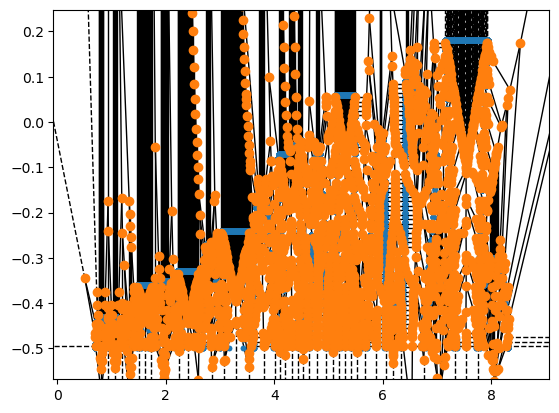

In [44]:
%matplotlib qt
voronoi_plot_2d(vor)